In [1]:
import pandas as pd
import numpy as np
import boxball_loader as bbl

In [2]:
years = range(2010, 2020)
stats = ['pa', 'runs_scored', 'hr', 's', 'd', 't', 'k', 'bb', 'ab']

agg_cols = stats + ['g', 'length_in_outs']

In [3]:
def get_gamelogs(years):
    # Narrow to years and regular-season games
    df = bbl.load_gamelogs(bbl.GameType.RS, years)

    # Add plate appearances and singles as stats we care about
    for HA in ['home', 'visitor']:
        df[f'{HA}_pa'] = df[f'{HA}_ab'] + df[f'{HA}_bb'] + df[f'{HA}_hbp'] + df[f'{HA}_sh'] + df[f'{HA}_sf']
        df[f'{HA}_s'] = df[f'{HA}_h'] - df[f'{HA}_d'] - df[f'{HA}_t'] - df[f'{HA}_hr']

    # These are the columns we care about
    standard_cols = ['yr', 'game_type', 'home_team', 'visiting_team', 'park_id', 'length_in_outs']
    stat_cols = [f'{HA}_{stat}' for HA in ['home', 'visitor'] for stat in stats]
    cols = standard_cols+stat_cols
    
    gl = df[cols].copy()
    gl['g'] = 1

    # For the stats, compute both teams' totals in each game
    for stat in stats:
        gl[stat] = gl['home_'+stat]+gl['visitor_'+stat]
    
    # Fix a bug in the Retrosheet data for the 2020 Rangers
    gl.loc[(gl['home_team']=='TEX')&(gl['yr']==2020), 'park_id'] = 'ARL03'
    
    return gl

In [4]:
gl = get_gamelogs(years)
gl

,yr,game_type,home_team,visiting_team,park_id,length_in_outs,home_pa,home_runs_scored,home_hr,home_s,...,g,pa,runs_scored,hr,s,d,t,k,bb,ab
165960,2010,RS,BOS,NYA,BOS07,51.0,39.0,9,1.0,7.0,...,1,82.0,16,3.0,15.0,5.0,1.0,7.0,10.0,71.0
165973,2010,RS,WAS,PHI,WAS11,54.0,37.0,1,0.0,5.0,...,1,86.0,12,2.0,15.0,4.0,1.0,15.0,12.0,73.0
165972,2010,RS,PIT,LAN,PIT08,51.0,41.0,11,3.0,3.0,...,1,83.0,16,3.0,11.0,8.0,0.0,8.0,6.0,71.0
165971,2010,RS,NYN,FLO,NYC20,51.0,38.0,7,1.0,4.0,...,1,73.0,8,1.0,8.0,5.0,1.0,12.0,6.0,64.0
165970,2010,RS,MIL,COL,MIL06,54.0,41.0,3,1.0,9.0,...,1,80.0,8,2.0,15.0,5.0,0.0,12.0,5.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,2019,RS,PHI,MIA,PHI13,54.0,43.0,3,2.0,10.0,...,1,76.0,7,5.0,13.0,2.0,0.0,19.0,3.0,73.0
8930,2019,RS,NYN,ATL,NYC20,65.0,47.0,7,3.0,11.0,...,1,92.0,13,7.0,17.0,2.0,0.0,26.0,5.0,86.0
8929,2019,RS,COL,MIL,DEN02,75.0,48.0,4,1.0,7.0,...,1,102.0,7,3.0,9.0,3.0,0.0,28.0,11.0,88.0
8928,2019,RS,ARI,SDN,PHO01,53.0,33.0,1,0.0,5.0,...,1,67.0,1,0.0,11.0,4.0,0.0,15.0,1.0,65.0


In [5]:
# Find each teams-season's primary park (the park in which they played the most home games)
def find_primary_parks(gl):
    hgbp = gl.groupby(['yr', 'home_team', 'park_id'])['g'].sum() # home games per park
    primary_parks = hgbp[hgbp.groupby(['yr', 'home_team']).transform(max) == hgbp].reset_index(level=-1)['park_id']
    return primary_parks

primary_parks = find_primary_parks(gl)
primary_parks

yr    home_team
2010  ANA          ANA01
      ARI          PHO01
      ATL          ATL02
      BAL          BAL12
      BOS          BOS07
                   ...  
2019  SLN          STL10
      TBA          STP01
      TEX          ARL02
      TOR          TOR02
      WAS          WAS11
Name: park_id, Length: 300, dtype: object

In [6]:
# Choose only the games where the home team was playing in its primary park (discard the rest)
g = pd.merge(left=gl, right=primary_parks.reset_index())
g

,yr,game_type,home_team,visiting_team,park_id,length_in_outs,home_pa,home_runs_scored,home_hr,home_s,...,g,pa,runs_scored,hr,s,d,t,k,bb,ab
0,2010,RS,BOS,NYA,BOS07,51.0,39.0,9,1.0,7.0,...,1,82.0,16,3.0,15.0,5.0,1.0,7.0,10.0,71.0
1,2010,RS,BOS,NYA,BOS07,54.0,38.0,4,1.0,5.0,...,1,81.0,10,2.0,9.0,7.0,0.0,15.0,6.0,70.0
2,2010,RS,BOS,NYA,BOS07,60.0,39.0,1,0.0,5.0,...,1,79.0,4,1.0,9.0,3.0,0.0,12.0,8.0,69.0
3,2010,RS,BOS,TBA,BOS07,72.0,46.0,1,1.0,3.0,...,1,90.0,4,2.0,6.0,3.0,0.0,19.0,8.0,82.0
4,2010,RS,BOS,TBA,BOS07,54.0,40.0,5,3.0,5.0,...,1,78.0,11,4.0,6.0,6.0,0.0,19.0,6.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24248,2019,RS,BOS,SFN,BOS07,54.0,35.0,3,2.0,4.0,...,1,80.0,14,3.0,15.0,3.0,0.0,16.0,6.0,73.0
24249,2019,RS,BOS,SFN,BOS07,51.0,39.0,5,0.0,7.0,...,1,79.0,9,0.0,13.0,4.0,0.0,26.0,9.0,69.0
24250,2019,RS,BOS,BAL,BOS07,54.0,32.0,1,0.0,3.0,...,1,74.0,5,1.0,6.0,5.0,0.0,18.0,10.0,63.0
24251,2019,RS,BOS,BAL,BOS07,54.0,40.0,4,2.0,7.0,...,1,82.0,13,6.0,12.0,3.0,0.0,17.0,9.0,72.0


In [7]:
# For each team-season, compute the totals in their home games and their road games

def compute_home_road_totals(gl):

    home_game_totals = gl.rename(columns={'home_team': 'tm'}).groupby(['yr', 'tm', 'park_id'])[agg_cols].sum().reset_index(level=-1)
    away_game_totals = gl.rename(columns={'visiting_team': 'tm'}).groupby(['yr', 'tm'])[agg_cols].sum()

    return home_game_totals, away_game_totals

home_game_totals, away_game_totals = compute_home_road_totals(g)
home_game_totals, away_game_totals


(         park_id      pa  runs_scored     hr       s      d     t       k  \
 yr   tm                                                                     
 2010 ANA   ANA01  6207.0          641  137.0   935.0  266.0  16.0  1125.0   
      ARI   PHO01  6232.0          793  201.0   922.0  300.0  46.0  1312.0   
      ATL   ATL02  6116.0          686  134.0   929.0  277.0  27.0  1200.0   
      BAL   BAL12  6293.0          736  178.0  1046.0  282.0  22.0  1042.0   
      BOS   BOS07  6318.0          812  169.0   927.0  366.0  17.0  1162.0   
 ...          ...     ...          ...    ...     ...    ...   ...     ...   
 2019 SLN   STL10  6026.0          682  182.0   839.0  229.0  21.0  1334.0   
      TBA   STP01  6141.0          673  189.0   812.0  274.0  30.0  1600.0   
      TEX   ARL02  6434.0          936  239.0   951.0  316.0  34.0  1429.0   
      TOR   TOR02  6255.0          789  270.0   787.0  292.0  21.0  1427.0   
      WAS   WAS11  6264.0          837  242.0   889.0  312.0  22

In [8]:
# Merge home and away totals into one DF
away_game_totals['park_id'] = home_game_totals['park_id']
home_game_totals['HA'] = 'H'
away_game_totals['HA'] = 'A'
tm_seasons = pd.concat([df.reset_index().set_index(['yr', 'tm', 'park_id', 'HA']) for df in [home_game_totals, away_game_totals]] ) \
    .sort_values(by=['yr', 'tm', 'park_id', 'HA'])
tm_seasons

pa  runs_scored     hr      s      d     t       k  \
yr   tm  park_id HA                                                           
2010 ANA ANA01   A   6128.0          742  166.0  908.0  323.0  34.0  1075.0   
                 H   6207.0          641  137.0  935.0  266.0  16.0  1125.0   
     ARI PHO01   A   6211.0          756  189.0  906.0  285.0  20.0  1287.0   
                 H   6232.0          793  201.0  922.0  300.0  46.0  1312.0   
     ATL ATL02   A   6187.0          681  131.0  912.0  297.0  30.0  1181.0   
...                     ...          ...    ...    ...    ...   ...     ...   
2019 TEX ARL02   H   6434.0          936  239.0  951.0  316.0  34.0  1429.0   
     TOR TOR02   A   6144.0          765  205.0  833.0  318.0  23.0  1419.0   
                 H   6255.0          789  270.0  787.0  292.0  21.0  1427.0   
     WAS WAS11   A   6136.0          760  191.0  854.0  267.0  23.0  1411.0   
                 H   6264.0          837  242.0  889.0  312.0  22.0  1408.0   

                        bb      ab   g  length_in_outs  
yr   tm  park_id HA                                     
2010 ANA ANA01   A   523.0  5512.0  81          4297.0  
                 H   508.0  5532.0  81          4410.0  
     ARI PHO01   A   587.0  5460.0  81          4308.0  
                 H   550.0  5554.0  81          4319.0  
     ATL ATL02   A   594.0  5456.0  81          4312.0  
...                    ...     ...  ..             ...  
2019 TEX ARL02   H   583.0  5714.0  81          4367.0  
     TOR TOR02   A   560.0  5479.0  81          4267.0  
                 H   553.0  5604.0  81          4416.0  
     WAS WAS11   A   546.0  5441.0  81          4291.0  
                 H   555.0  5562.0  81          4307.0  

[600 rows x 11 columns]

In [9]:
# Sum from team-seasons to park totals
park_totals = tm_seasons.groupby(['park_id', 'HA']).sum()
park_totals

pa  runs_scored      hr       s       d      t        k  \
park_id HA                                                                 
ANA01   A   61575.0         7483  1864.0  9248.0  2852.0  266.0  11806.0   
        H   61061.0         6788  1731.0  9123.0  2557.0  188.0  12188.0   
ARL02   A   60799.0         6931  1772.0  8960.0  2709.0  232.0  12367.0   
        H   62555.0         8231  1997.0  9817.0  2889.0  306.0  11768.0   
ATL02   A   42794.0         4569  1041.0  6499.0  1861.0  199.0   8457.0   
...             ...          ...     ...     ...     ...    ...      ...   
STP01   H   60499.0         6361  1631.0  8461.0  2436.0  277.0  13670.0   
TOR02   A   61720.0         7340  1876.0  8954.0  2806.0  230.0  12378.0   
        H   61571.0         7554  2134.0  8506.0  3130.0  242.0  12534.0   
WAS11   A   61187.0         6793  1669.0  8822.0  2608.0  299.0  13218.0   
        H   61411.0         6973  1708.0  9412.0  2768.0  213.0  12835.0   

                bb       ab    g  length_in_outs  
park_id HA                                        
ANA01   A   5154.0  55140.0  810         43193.0  
        H   4851.0  54906.0  808         43503.0  
ARL02   A   4851.0  54639.0  807         43091.0  
        H   5182.0  55962.0  811         43158.0  
ATL02   A   3527.0  38291.0  566         30392.0  
...            ...      ...  ...             ...  
STP01   H   5090.0  54150.0  807         43378.0  
TOR02   A   5282.0  55213.0  810         43459.0  
        H   5138.0  55249.0  807         43268.0  
WAS11   A   4996.0  54646.0  810         43449.0  
        H   4843.0  55109.0  809         43318.0  

[64 rows x 11 columns]

In [10]:
park_totals.loc['LOS03']

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
HA,,,,,,,,,,,
A,61302.0,6965,1589.0,9033.0,2658.0,350.0,13165.0,5280.0,54574.0,804,43177.0
H,60270.0,6304,1654.0,8697.0,2557.0,150.0,13326.0,4762.0,54109.0,811,43275.0


In [11]:
# Convert to rates relative to PA
park_rates = park_totals[agg_cols].divide(park_totals['pa'], axis=0) 
park_rates

pa  runs_scored        hr         s         d         t  \
park_id HA                                                             
ANA01   A   1.0     0.121527  0.030272  0.150191  0.046317  0.004320   
        H   1.0     0.111168  0.028349  0.149408  0.041876  0.003079   
ARL02   A   1.0     0.113999  0.029145  0.147371  0.044557  0.003816   
        H   1.0     0.131580  0.031924  0.156934  0.046183  0.004892   
ATL02   A   1.0     0.106767  0.024326  0.151867  0.043487  0.004650   
...         ...          ...       ...       ...       ...       ...   
STP01   H   1.0     0.105142  0.026959  0.139854  0.040265  0.004579   
TOR02   A   1.0     0.118924  0.030395  0.145075  0.045463  0.003727   
        H   1.0     0.122688  0.034659  0.138149  0.050836  0.003930   
WAS11   A   1.0     0.111020  0.027277  0.144181  0.042623  0.004887   
        H   1.0     0.113546  0.027813  0.153262  0.045073  0.003468   

                   k        bb        ab         g  length_in_outs  
park_id HA                                                          
ANA01   A   0.191734  0.083703  0.895493  0.013155        0.701470  
        H   0.199604  0.079445  0.899199  0.013233        0.712451  
ARL02   A   0.203408  0.079787  0.898683  0.013273        0.708745  
        H   0.188122  0.082839  0.894605  0.012965        0.689921  
ATL02   A   0.197621  0.082418  0.894775  0.013226        0.710193  
...              ...       ...       ...       ...             ...  
STP01   H   0.225954  0.084134  0.895056  0.013339        0.717004  
TOR02   A   0.200551  0.085580  0.894572  0.013124        0.704132  
        H   0.203570  0.083448  0.897322  0.013107        0.702733  
WAS11   A   0.216026  0.081651  0.893098  0.013238        0.710102  
        H   0.209002  0.078862  0.897380  0.013174        0.705379  

[64 rows x 11 columns]

In [12]:
# divide home rates by away rates to get observed park factors
pr = park_rates.reset_index(level=-1)
pfs = pr[pr['HA']=='H'][agg_cols]/pr[pr['HA']=='A'][agg_cols]
pfs

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
park_id,,,,,,,,,,,
ANA01,1.0,0.914759,0.936465,0.994788,0.904111,0.712716,1.041047,0.949134,1.004138,1.005928,1.015655
ARL02,1.0,1.154227,1.095340,1.064891,1.036509,1.281940,0.924853,1.038247,0.995462,0.976746,0.973440
ATL02,1.0,0.985037,0.898464,1.009554,0.956297,0.853633,1.067193,1.027868,0.994816,0.999253,0.998398
ATL03,1.0,1.033974,0.935820,1.026386,1.060303,0.802529,0.977380,0.979335,1.000705,1.005836,0.996539
BAL12,1.0,1.040565,1.178537,1.017224,0.955662,0.727490,0.952078,0.991189,1.001855,0.992280,0.995464
BOS07,1.0,1.087855,0.898092,1.038693,1.310320,1.066352,0.971678,0.984617,1.001988,0.989957,0.979557
CHI11,1.0,1.015901,0.998181,1.000620,0.991897,1.127995,1.000298,1.043803,0.993715,0.999467,0.996061
CHI12,1.0,1.012916,1.182084,0.965063,0.909427,0.772340,1.048302,1.091057,0.992942,0.998847,0.994972
CIN09,1.0,1.037883,1.230079,0.969577,0.960161,0.837326,1.074650,1.036318,0.998752,0.995216,0.996229


In [13]:
# Put it all together into one function

def get_pfs(years, min_games = 0):
    gl = get_gamelogs(years)
    primary_parks = find_primary_parks(gl)

    # Choose only the games where the home team was playing in its primary park (discard the rest)
    g = pd.merge(left=gl, right=primary_parks.reset_index())

    home_game_totals, away_game_totals = compute_home_road_totals(g)

    # Merge home and away totals into one DF
    away_game_totals['park_id'] = home_game_totals['park_id']
    home_game_totals['HA'] = 'H'
    away_game_totals['HA'] = 'A'
    tm_seasons = pd.concat([df.reset_index().set_index(['yr', 'tm', 'park_id', 'HA']) for df in [home_game_totals, away_game_totals]] ) \
        .sort_values(by=['yr', 'tm', 'park_id', 'HA'])
    
    # Sum from team-seasons to park totals
    park_totals = tm_seasons.groupby(['park_id', 'HA']).sum()

    # Enforce min_games minimum
    park_totals = park_totals[park_totals['g'] > min_games]

    # Convert to rates relative to PA
    park_rates = park_totals[agg_cols].divide(park_totals['pa'], axis=0)

    # divide home rates by away rates to get observed park factors
    pr = park_rates.reset_index(level=-1)
    pfs = pr[pr['HA']=='H'][agg_cols]/pr[pr['HA']=='A'][agg_cols]

    return pfs

get_pfs(range(2015, 2021), 100)


,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
park_id,,,,,,,,,,,
ANA01,1.0,0.961210,1.052603,0.978751,0.908771,0.712700,1.034365,0.978731,1.003404,1.000170,1.012386
ARL02,1.0,1.180221,1.071480,1.093065,1.080777,1.345389,0.907081,1.069107,0.992866,0.965743,0.965621
ATL02,1.0,0.984559,0.736148,0.992798,0.921715,0.822915,1.042677,1.109277,0.985371,0.984559,0.997072
ATL03,1.0,1.038187,0.938022,1.037051,1.044070,0.788087,0.975630,0.993334,0.998851,1.004811,0.992700
BAL12,1.0,1.028462,1.174735,1.019056,0.905925,0.763720,0.939260,0.982926,1.002084,0.993511,0.997732
BOS07,1.0,1.100352,0.926001,1.042978,1.321474,1.139850,0.961876,0.966509,1.003345,0.989532,0.977721
CHI11,1.0,0.983970,0.968013,0.986011,0.962335,1.239373,0.989848,1.043882,0.990814,1.014180,0.999576
CHI12,1.0,0.962627,1.131903,0.964174,0.856386,0.739072,1.044626,1.041868,0.995720,1.006029,1.005563
CIN09,1.0,1.050719,1.205279,0.959376,0.992924,0.718227,1.082657,1.050617,0.997846,0.984696,0.994582


In [14]:
pfs.to_csv('../data/mine/park_factors.csv')

In [15]:
import seaborn as sns

<AxesSubplot:ylabel='park_id'>

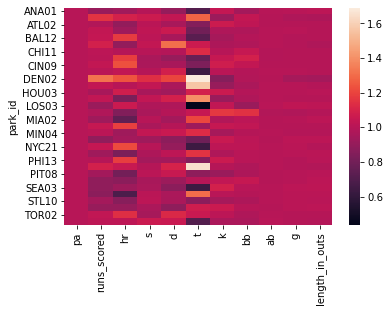

In [16]:
sns.heatmap(pfs)

# Now compute effects on scoring from component park factors

In [17]:
# Generate a league-average stat line (scaled to 1 PA)
event_freqs = home_game_totals[stats].sum()/home_game_totals['pa'].sum()
event_freqs

pa             1.000000
runs_scored    0.115339
hr             0.028091
s              0.149604
d              0.045001
t              0.004626
k              0.205512
bb             0.081548
ab             0.896183
dtype: float64

In [18]:
def compute_obp(stats):
    stats['ob'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']+ stats['bb']
    obp = stats['ob']/stats['pa']
    return obp


In [19]:
def compute_ba(stats):
    stats['h'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']
    ba = stats['h']/stats['ab']
    return ba


In [20]:
def compute_base_runs(stats):
    stats['tb'] =  stats['s'] + 2* stats['d'] + 3* stats['t'] + 4* stats['hr']
    stats['h'] =  stats['s'] +  stats['d'] +  stats['t'] +  stats['hr']
    a = stats['h'] + stats['bb'] - stats['hr']
    b = (1.4 * stats['tb'] - .6 * stats['h'] - 3 * stats['hr'] + .1 * stats['bb']) * 1.02
    c = stats['ab'] - stats['h']
    d = stats['hr'] 
    return (a*b)/(b+c)+d


In [21]:
def compute_woba(stats):
    woba_weights = {'ob': .702, 'tb': .37, 'h': -.21}
    stats['ob'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']+ stats['bb']
    stats['tb'] =  stats['s'] + 2* stats['d'] + 3* stats['t'] + 4* stats['hr']
    stats['h'] =  stats['s'] +  stats['d'] +  stats['t'] +  stats['hr']

    woba = sum([stats[stat]*woba_weights[stat] for stat in woba_weights.keys()])/stats['pa']
    return woba
                

In [22]:
# compare total runs to total BaseRuns
home_game_totals['runs_scored'].sum(), compute_base_runs(home_game_totals[stats].sum())

(212817, 214333.9581329418)

In [23]:
# league-total obp
compute_obp(event_freqs)

0.3088708235102837

In [24]:
# league-total woba
compute_woba(home_game_totals[stats].sum())

0.3044543673956047

In [25]:
# league-total woba -- should be the same
compute_woba(event_freqs)

0.30445436739560466

In [26]:
# This is the relative difference in PA/outs between two OBPs
# Outs/PA is 1-OBP, so it follows from there.
# Can call this with obp1 as adjusted OBP and obp2 as league/baseline OBP
def compute_pa_adj(obp1, obp2):
    return ((1-obp2)/(1-obp1))

In [27]:
compute_pa_adj(.350, .3)

1.0769230769230769

In [28]:
# Take the league-average line and adjust it by component PFs
def compute_adj_freqs(pfs):
    events = ['s', 'd', 't', 'hr', 'bb', 'ab']
    return pfs[events] * event_freqs[events]


In [29]:
compute_adj_freqs(pfs)

,s,d,t,hr,bb,ab
park_id,,,,,,
ANA01,0.148824,0.040686,0.003297,0.026307,0.077400,0.899892
ARL02,0.159312,0.046644,0.005930,0.030770,0.084667,0.892117
ATL02,0.151033,0.043035,0.003949,0.025239,0.083820,0.891538
ATL03,0.153552,0.047715,0.003713,0.026289,0.079863,0.896814
BAL12,0.152181,0.043006,0.003366,0.033107,0.080829,0.897846
BOS07,0.155393,0.058966,0.004933,0.025229,0.080293,0.897965
CHI11,0.149697,0.044637,0.005218,0.028040,0.085120,0.890551
CHI12,0.144377,0.040925,0.003573,0.033206,0.088973,0.889858
CIN09,0.145053,0.043208,0.003874,0.034555,0.084510,0.895064


In [30]:
# Compute the park-adjusted league-average lines
adj_freqs = compute_adj_freqs(pfs)
adj_freqs['pa'] = 1

# Compute a few stats on these adjusted lines
pfs['woba'] = compute_woba(adj_freqs)
pfs['bsr'] = compute_base_runs(adj_freqs)
pfs['obp'] = compute_obp(adj_freqs)
pfs['ba'] = compute_ba(adj_freqs)

# Compute pfs by comparing the adjusted lines to unadjusted
pfs['pf_pa_exp'] = compute_pa_adj(pfs['obp'], compute_obp(event_freqs))
pfs['pf_woba'] = pfs['woba']/compute_woba(event_freqs)
pfs['pf_bsr'] = pfs['bsr']/compute_base_runs(event_freqs)
pfs['pf_ba'] = pfs['ba']/compute_ba(event_freqs)

pfs['papg'] = 1/pfs['g']
pfs['papo'] = 1/pfs['length_in_outs']

pfs

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,...,woba,bsr,obp,ba,pf_pa_exp,pf_woba,pf_bsr,pf_ba,papg,papo
park_id,,,,,,,,,,,,,,,,,,,,,
ANA01,1.0,0.914759,0.936465,0.994788,0.904111,0.712716,1.041047,0.949134,1.004138,1.005928,...,0.289905,0.106322,0.296514,0.243490,0.982435,0.952213,0.915300,0.959917,0.994107,0.984586
ARL02,1.0,1.154227,1.095340,1.064891,1.036509,1.281940,0.924853,1.038247,0.995462,0.976746,...,0.324407,0.130252,0.327323,0.272001,1.027431,1.065536,1.121311,1.072318,1.023807,1.027285
ATL02,1.0,0.985037,0.898464,1.009554,0.956297,0.853633,1.067193,1.027868,0.994816,0.999253,...,0.298149,0.111419,0.307077,0.250417,0.997411,0.979291,0.959177,0.987228,1.000748,1.001605
ATL03,1.0,1.033974,0.935820,1.026386,1.060303,0.802529,0.977380,0.979335,1.000705,1.005836,...,0.304999,0.116359,0.311130,0.257877,1.003280,1.001787,1.001709,1.016637,0.994198,1.003473
BAL12,1.0,1.040565,1.178537,1.017224,0.955662,0.727490,0.952078,0.991189,1.001855,0.992280,...,0.311584,0.121598,0.312489,0.258017,1.005262,1.023417,1.046811,1.017188,1.007780,1.004556
BOS07,1.0,1.087855,0.898092,1.038693,1.310320,1.066352,0.971678,0.984617,1.001988,0.989957,...,0.320615,0.127141,0.324814,0.272305,1.023613,1.053079,1.094529,1.073518,1.010145,1.020870
CHI11,1.0,1.015901,0.998181,1.000620,0.991897,1.127995,1.000298,1.043803,0.993715,0.999467,...,0.307440,0.118214,0.312712,0.255563,1.005589,1.009808,1.017678,1.007516,1.000533,1.003954
CHI12,1.0,1.012916,1.182084,0.965063,0.909427,0.772340,1.048302,1.091057,0.992942,0.998847,...,0.308540,0.119254,0.311056,0.249570,1.003171,1.013419,1.026633,0.983890,1.001155,1.005053
CIN09,1.0,1.037883,1.230079,0.969577,0.960161,0.837326,1.074650,1.036318,0.998752,0.995216,...,0.311941,0.121951,0.311199,0.253266,1.003380,1.024592,1.049843,0.998460,1.004807,1.003785


In [31]:
import plotly.express as px

In [32]:
# How does the composite BaseRuns-based pf do against runs/PA?
px.scatter(pfs.reset_index(), y='runs_scored', x='pf_bsr', trendline="ols", hover_name='park_id')

In [33]:
# How does the adjusted-OBP estimate of PA adjustment do against observed PA/out and PA/game?
px.scatter(pfs.reset_index(), y=['papo', 'papg'], x='pf_pa_exp', trendline="ols", hover_name='park_id')

In [34]:
pfs.sort_values(by='t')

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,...,woba,bsr,obp,ba,pf_pa_exp,pf_woba,pf_bsr,pf_ba,papg,papo
park_id,,,,,,,,,,,,,,,,,,,,,
LOS03,1.0,0.920595,1.058730,0.979289,0.978474,0.435910,1.029562,0.917337,1.008457,1.025978,...,0.294931,0.110335,0.297103,0.245968,0.983258,0.968719,0.949848,0.969686,0.974679,0.980939
CLE08,1.0,1.013745,1.030422,0.999154,1.086434,0.634397,1.014072,0.990932,1.002674,0.999848,...,0.307594,0.118289,0.311058,0.256237,1.003174,1.010312,1.018325,1.010172,1.000152,1.001680
SEA03,1.0,0.888239,0.928992,0.969953,0.873153,0.640340,1.090769,1.006765,1.001189,1.018148,...,0.287335,0.104197,0.295560,0.237906,0.981105,0.943771,0.897008,0.937905,0.982175,0.980051
NYC21,1.0,1.043245,1.218352,1.000612,0.905187,0.640587,1.021497,1.019280,0.999721,1.011773,...,0.309813,0.120432,0.310739,0.254058,1.002710,1.017600,1.036774,1.001581,0.988364,1.006002
WAS11,1.0,1.022754,1.019634,1.062987,1.057478,0.709776,0.967482,0.965840,1.004794,0.995122,...,0.312745,0.121733,0.317304,0.264905,1.012352,1.027231,1.047969,1.044344,1.004902,1.006696
ANA01,1.0,0.914759,0.936465,0.994788,0.904111,0.712716,1.041047,0.949134,1.004138,1.005928,...,0.289905,0.106322,0.296514,0.243490,0.982435,0.952213,0.915300,0.959917,0.994107,0.984586
BAL12,1.0,1.040565,1.178537,1.017224,0.955662,0.727490,0.952078,0.991189,1.001855,0.992280,...,0.311584,0.121598,0.312489,0.258017,1.005262,1.023417,1.046811,1.017188,1.007780,1.004556
CHI12,1.0,1.012916,1.182084,0.965063,0.909427,0.772340,1.048302,1.091057,0.992942,0.998847,...,0.308540,0.119254,0.311056,0.249570,1.003171,1.013419,1.026633,0.983890,1.001155,1.005053
NYC20,1.0,0.887261,0.947816,0.932729,0.879173,0.792894,1.056562,1.018561,0.997312,1.018170,...,0.285717,0.103594,0.292459,0.234285,0.976804,0.938456,0.891814,0.923628,0.982154,0.981604


In [35]:
pfs.T

park_id,ANA01,ARL02,ATL02,ATL03,BAL12,BOS07,CHI11,CHI12,CIN09,CLE08,...,PHI13,PHO01,PIT08,SAN02,SEA03,SFO03,STL10,STP01,TOR02,WAS11
pa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
runs_scored,0.914759,1.154227,0.985037,1.033974,1.040565,1.087855,1.015901,1.012916,1.037883,1.013745,...,0.995581,1.089720,0.944806,0.891401,0.888239,0.875845,0.946355,0.909811,1.031646,1.022754
hr,0.936465,1.095340,0.898464,0.935820,1.178537,0.898092,0.998181,1.182084,1.230079,1.030422,...,1.182544,1.050426,0.806770,0.875758,0.928992,0.686227,0.863501,0.906807,1.140279,1.019634
s,0.994788,1.064891,1.009554,1.026386,1.017224,1.038693,1.000620,0.965063,0.969577,0.999154,...,0.948203,0.996123,1.012971,0.956061,0.969953,1.013685,1.014659,0.968848,0.952265,1.062987
d,0.904111,1.036509,0.956297,1.060303,0.955662,1.310320,0.991897,0.909427,0.960161,1.086434,...,0.944571,1.101585,1.051131,0.923003,0.873153,0.968992,0.963230,0.883244,1.118166,1.057478
t,0.712716,1.281940,0.853633,0.802529,0.727490,1.066352,1.127995,0.772340,0.837326,0.634397,...,0.862111,1.653607,0.886204,1.003954,0.640340,1.307385,0.874080,1.073347,1.054720,0.709776
k,1.041047,0.924853,1.067193,0.977380,0.952078,0.971678,1.000298,1.048302,1.074650,1.014072,...,1.060050,0.996519,0.920452,1.030420,1.090769,1.006417,0.951753,1.059478,1.015053,0.967482
bb,0.949134,1.038247,1.027868,0.979335,0.991189,0.984617,1.043803,1.091057,1.036318,0.990932,...,1.006887,0.975858,0.974020,1.044133,1.006765,0.998462,0.972135,1.001257,0.975092,0.965840
ab,1.004138,0.995462,0.994816,1.000705,1.001855,1.001988,0.993715,0.992942,0.998752,1.002674,...,1.000096,1.001816,0.999225,0.998231,1.001189,1.000109,1.000165,0.999388,1.003074,1.004794
g,1.005928,0.976746,0.999253,1.005836,0.992280,0.989957,0.999467,0.998847,0.995216,0.999848,...,0.994187,0.991161,1.004285,1.003421,1.018148,1.009458,1.011466,1.013967,0.998707,0.995122
